## Important parameters
<br>xt_ocean: longitude, length 3600
<br>yt_ocean: latitude, length 1500
<br> [mind map](https://miro.com/app/board/o9J_lM4N1Pg=/?fromRedirect=1)

In [1]:
import netCDF4 as nc4
import keras
import xarray,numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import  Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils
from tensorflow.keras import layers

# Load data

In [2]:
import glob
input_data_split = []
for np_name in glob.glob('raw data/128/dataset_128_N102/*.np[yz]'):
    input_data_split.append(np.load(np_name))
input_data_split = np.array(input_data_split)

# Fix Missing Value

In [3]:
def fix_missing_value(input_data):
    """
    input 3d matrix
    """
    for i in range(0,len(input_data)):
        arr = input_data[i]
        arr[np.isnan(arr)] = 0
    return input_data

# Min Max Scaling

In [4]:
def min_max_scale(input_data, max_value, min_value):
    """
    input 3d matrix
    """
#     max_value = np.amax(input_data)
#     min_value = np.amin(input_data)
    for i in range(len(input_data)):
        input_data[i] = (input_data[i] - min_value)/(max_value - min_value)
    return input_data

# Preprocessing

In [5]:
import random
n = 2000 # sample size
input_data_split = np.array(random.sample(input_data_split.tolist(),n))
input_data_split.shape

(2000, 128, 128, 1)

In [6]:
input_data_split = fix_missing_value(input_data_split)
max_value = np.amax(input_data_split)
min_value = np.amin(input_data_split)
input_data_split_scaled = min_max_scale(input_data_split, max_value, min_value)

In [7]:
input_data_split_scaled.shape

(2000, 128, 128, 1)

# split train set & validation set

In [8]:
train_set, test_set = train_test_split(input_data_split, test_size=0.3333333, random_state=26)

train_set_scaled, test_set_scaled = train_test_split(input_data_split_scaled, test_size=0.3333333, random_state=26)
np.array(train_set_scaled).shape

(1333, 128, 128, 1)

# Autoencoder

In [29]:
lat = 128 # chunk size
long = 128 # chunk size

input_img = keras.Input(shape=(lat, long,1))

x = layers.Conv2D(64,(4,4), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (4, 4), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (4, 4), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (4, 4), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (4, 4), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = layers.Conv2D(2, (4, 4), activation='relu',strides=(1,1), padding='same')(x)
# encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2DTranspose(8, (4, 4), strides=(2, 2),activation='relu', padding='same')(encoded)
x = layers.Conv2DTranspose(16, (4, 4), strides=(2, 2),activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (4, 4), strides=(2, 2),activation='relu', padding='same')(x)
# x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), activation='relu')(x)
x = layers.Conv2DTranspose(64, (4, 4), strides=(1, 1),activation='relu', padding='same')(x)
# x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2),activation='relu', padding='same')(x)
decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 64)      1088      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 32)        32800     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 16)        8208      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 16)        0   

In [10]:
history = autoencoder.fit(train_set_scaled, train_set_scaled,
                epochs=10, validation_data=(test_set_scaled, test_set_scaled))

Epoch 1/10
42/42 [==============================] - 171s 4s/step - loss: 0.0270 - val_loss: 0.0141
Epoch 2/10
42/42 [==============================] - 175s 4s/step - loss: 0.0131 - val_loss: 0.0089
Epoch 3/10
42/42 [==============================] - 177s 4s/step - loss: 0.0079 - val_loss: 0.0074
Epoch 4/10
42/42 [==============================] - 166s 4s/step - loss: 0.0069 - val_loss: 0.0064
Epoch 5/10
42/42 [==============================] - 168s 4s/step - loss: 0.0059 - val_loss: 0.0065
Epoch 6/10
42/42 [==============================] - 155s 4s/step - loss: 0.0050 - val_loss: 0.0048
Epoch 7/10
42/42 [==============================] - 135s 3s/step - loss: 0.0041 - val_loss: 0.0035
Epoch 8/10
42/42 [==============================] - 128s 3s/step - loss: 0.0037 - val_loss: 0.0028
Epoch 9/10
42/42 [==============================] - 125s 3s/step - loss: 0.0025 - val_loss: 0.0020
Epoch 10/10
42/42 [==============================] - 144s 3s/step - loss: 0.0020 - val_loss: 0.0017


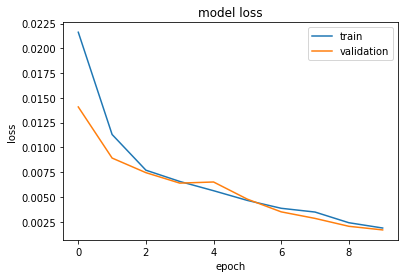

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [26]:
test_sample_index = 111

# select a sample
original_data = test_set[test_sample_index]
original_data.shape

test_data = (original_data - min_value)/(max_value - min_value) # preprocessing
test_data.shape

decoded_data = autoencoder.predict(np.expand_dims(test_data, 0)) 
decoded_data = decoded_data*(max_value-min_value) + min_value   # scale back

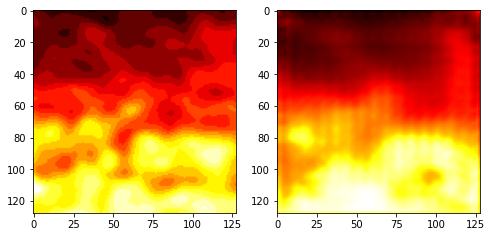

In [36]:
fig = plt.figure(figsize=(16,16)) # image
ax1 = fig.add_subplot(1,2,1) 
ax1.imshow(original_sample_data,cmap='hot')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(decoded_data.reshape(128,128),cmap='hot')

In [27]:
mse = np.square((original_data-decoded_data)).mean()
mse

0.001398844057015632